# Bitcoin Linear Regression

## Introduction

- The USD for example is backed by trust in the US Government and as the world’s reserve currency.
	- US Government continues to put more currency into circulation.
	- More currency into circulation devalues the currency over time.
	- USD is not currently backed by anything of physical value other than the US government
- The value of BTC is merely based on the law of supply and demand. 
	- BTC has a cap on the amount of coins that can be produced, 21 million.
	- Due to the supply being limited to 21 million, as demand increases the value will likely increase.

- The likelihood of the United States adopting BTC as its universal currency is small
- Some countries that are susceptible to significant currency manipulation, like hyperinflation, may be enticed to use bitcoin. 
- Individuals may revert to BTC so that their money holds value

## Goal
Identify features around the Bitcoin blockchain that might have an impact on the price of bitcoin, such as, market capitalization, transaction volume, miners revenue, transactions per block, estimated volume, average block size, hash rate, number of orphan blocks...



## Proposed Method
A multiple linear regression model where multiple explanatory variables will help us in predicting the price of bitcoin. Several independent variables are explored and analyzed. After the analysis, the most correlated variables with the price of bitcoin are selected.
First, the dataset is read and its data is pre-processed. Next, we examine the historical value of bitcoin over time. After that, we will review the correlation between variables to see which one will be included in the linear regression analysis.

In [86]:
!pip install requests pandas numpy matplotlib seaborn sklearn statsmodels


You should consider upgrading via the '/Users/alvaroserranorivas/.pyenv/versions/3.9.2/envs/bitcoin_linear_regression/bin/python3.9 -m pip install --upgrade pip' command.


In [87]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from datetime import datetime
import time
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [88]:
USD= 2208000000000 # USD in circulation as of Nov 6, 2021 according to https://ycharts.com/indicators/us_currency_in_circulation
Bitcoin=21000000   # 21 Million Bitcoin (Most Bitcoin that will be in Circulation)
Value=USD/Bitcoin  # Value of Bitcoin compared to the current dollar
print(f"USD/BTC in circulation: {Value}")
# Get current USD/BTC price from https://www.coindesk.com/price/
session = requests.Session()
USD_BTC_rate = session.get("https://api.coindesk.com/v1/bpi/currentprice.json").json()["bpi"]["USD"]["rate_float"]
print(f"Current USD/BTC rate: {USD_BTC_rate}")

USD/BTC in circulation: 105142.85714285714
Current USD/BTC rate: 62715.8661


## Data set description

In [89]:
BTC_data = pd.read_csv("bitcoin_dataset.csv", header=0)
print(BTC_data.head())
print(BTC_data.columns)
print(BTC_data.shape)
BTC_data["Date"] = BTC_data["Date"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
# Create a Days column that is the number of days for each row
BTC_data["Days"] = (BTC_data["Date"] - BTC_data["Date"].min()).dt.days
# Print subset of data where Median Confirmation Time is greater than 0
print(BTC_data[BTC_data["btc_median_confirmation_time"] > 0])
# Subset where Median Confirmation Time is greater than 0
BTC_data2 = BTC_data[BTC_data["btc_median_confirmation_time"] > 0]



                  Date  btc_market_price  btc_total_bitcoins  btc_market_cap  \
0  2009-11-10 00:00:00               0.0           1339450.0             0.0   
1  2009-11-11 00:00:00               0.0           1342900.0             0.0   
2  2009-11-12 00:00:00               0.0           1346400.0             0.0   
3  2009-11-13 00:00:00               0.0           1349900.0             0.0   
4  2009-11-14 00:00:00               0.0           1354050.0             0.0   

   btc_trade_volume  btc_blocks_size  btc_avg_block_size  \
0               0.0              0.0            0.000215   
1               0.0              0.0            0.000323   
2               0.0              0.0            0.000215   
3               0.0              0.0            0.000242   
4               0.0              0.0            0.000216   

   btc_n_orphaned_blocks  btc_n_transactions_per_block  \
0                    0.0                           1.0   
1                    0.0                  

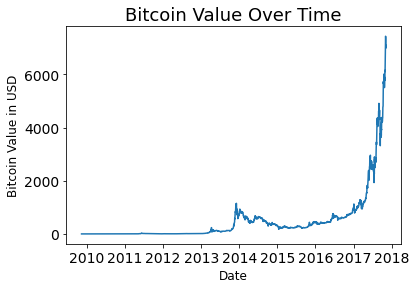

In [90]:
# Plot btc_market_price vs Date with a scatter plot
plt.plot(BTC_data["Date"], BTC_data["btc_market_price"])
plt.title("Bitcoin Value Over Time")
plt.xlabel("Date")
plt.ylabel("Bitcoin Value in USD")
plt.show()

We can see that the value of bitcoin has grown exponentially.


## Exploratory data analysis to data set
Since market fluctuations are hard to predict and we can only analyze observational data of the past, and model based on percent change will give an accurate picture of the correlation between the most significant variables affecting bitcoin’s market price. Therefore, as price increases, so will the relative variations of the highest dependent features of Bitcoin’s blockchain. This corroborates the initial hypothesis that bitcoin’s price is dictated by the law of supply and demand. The reason for that is that eventually the percent change in the count of bitcoin will become irrelevant because of its finite supply of 21 million coins.


#### Correlation between variables

                                                    btc_avg_block_size  \
btc_avg_block_size                                            1.000000   
btc_n_orphaned_blocks                                         0.921531   
btc_n_transactions_per_block                                  0.999818   
btc_median_confirmation_time                                  0.979275   
btc_hash_rate                                                -0.756919   
btc_difficulty                                               -0.737205   
btc_miners_revenue                                           -0.791462   
btc_transaction_fees                                         -0.559594   
btc_cost_per_transaction_percent                             -0.943949   
btc_cost_per_transaction                                     -0.456912   
btc_n_unique_addresses                                        0.996330   
btc_n_transactions                                            0.999945   
btc_n_transactions_total              

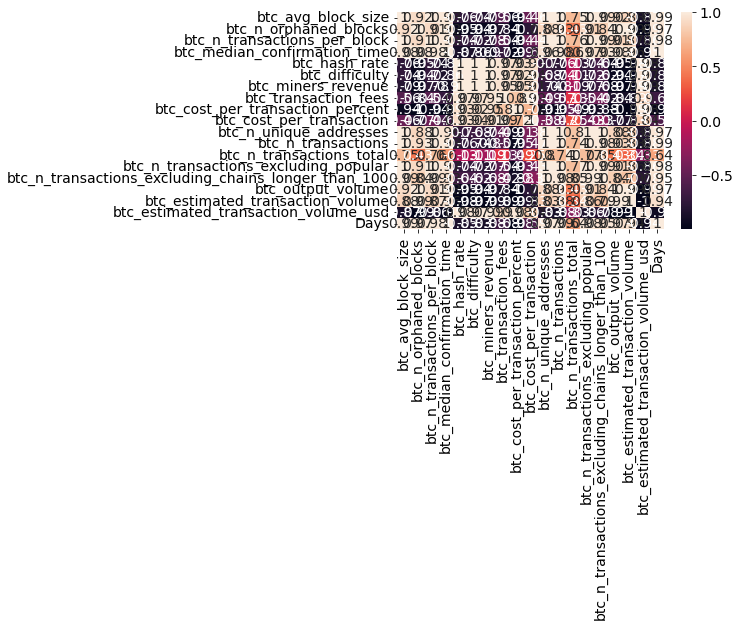

In [91]:

corr = BTC_data.corr()
corr = corr.iloc[1:4, 5:25].corr()
# Plot correlation matrix
sns.heatmap(corr, annot=True, xticklabels=corr.columns, yticklabels=corr.columns)
print(corr)



The most correlated variables to Market Price are Market Cap, Hash Rate, Difficulty, Miner Revenue, and Estimated USD Transaction Volume



### Market Cap and Market Price

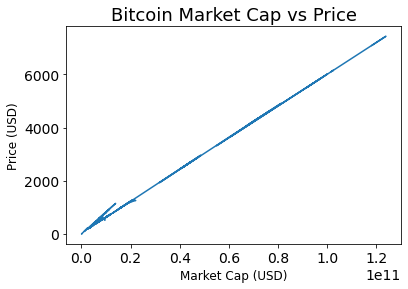

In [92]:
# Plot btc_market_cap vs btc_market_price with a scatter plot
plt.plot(BTC_data2["btc_market_cap"], BTC_data2["btc_market_price"])
# Market Cap vs Price
plt.title("Bitcoin Market Cap vs Price")
plt.xlabel("Market Cap (USD)")
plt.ylabel("Price (USD)")
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)
plt.show()


Coefficients: [5.99399412e-08]
Intercept: 46.35026420098336
Mean squared error: 2453.95
Variance score: 1.00


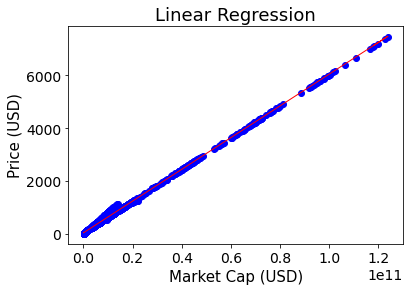

In [93]:
# Create a linear regression object
fit1 = linear_model.LinearRegression(fit_intercept=True, copy_X=True, n_jobs=1)
# Train the model using the training sets
fit1.fit(BTC_data2[["btc_market_cap"]], BTC_data2["btc_market_price"])
# Make predictions using the testing set
predictions = fit1.predict(BTC_data2[["btc_market_cap"]])
# Residuals
residuals = BTC_data2["btc_market_price"] - predictions
# The coefficients
print(f'Coefficients: {fit1.coef_}')
# Intercept
print(f'Intercept: {fit1.intercept_}')
# The mean squared error
print("Mean squared error: %.2f"
	  % np.mean((predictions - BTC_data2["btc_market_price"]) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % fit1.score(BTC_data2[["btc_market_cap"]], BTC_data2["btc_market_price"]))
# Plot outputs
plt.scatter(BTC_data2["btc_market_cap"], BTC_data2["btc_market_price"],  color='blue')
plt.plot(BTC_data2["btc_market_cap"], predictions, color='red', linewidth=1)
plt.title('Linear Regression')
plt.xlabel('Market Cap (USD)')
plt.ylabel('Price (USD)')
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)
plt.show()



Since R-Squared is very close to 1, Market Capitalization is signficant to Market Price.



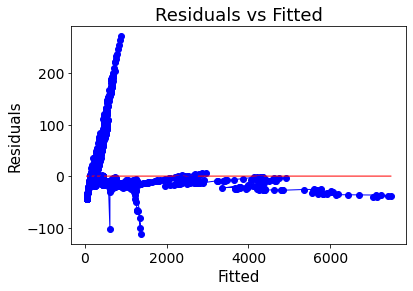

In [94]:
# Residuals vs fitted plot
plt.scatter(predictions, residuals,  color='blue')
plt.xticks(np.arange(0, max(predictions), step=2000))
plt.yticks(np.arange(-100, 300, step=100))
plt.plot(np.unique(predictions), np.poly1d(np.polyfit(predictions, residuals, 1))(np.unique(predictions)), color='red', linewidth=1)
plt.plot(predictions, residuals, color='blue', linewidth=1)
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted')
plt.ylabel('Residuals')
plt.show()



### Estimated USD Transaction Volume vs. Market Price

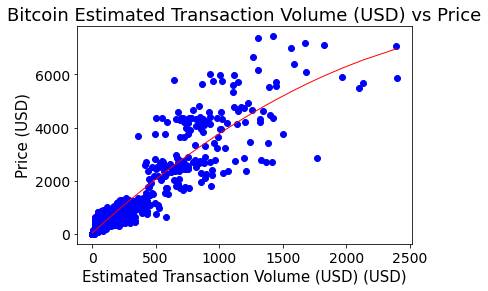

In [95]:
# Plot btc_estimated_transaction_volume_usd vs btc_market_price with a scatter plot
plt.plot(BTC_data2["btc_estimated_transaction_volume_usd"]/1000000, BTC_data2["btc_market_price"], 'o', color='blue', linewidth=1)
plt.plot(np.unique(BTC_data2["btc_estimated_transaction_volume_usd"]/1000000), np.poly1d(np.polyfit(BTC_data2["btc_estimated_transaction_volume_usd"]/1000000, BTC_data2["btc_market_price"], 2))(np.unique(BTC_data2["btc_estimated_transaction_volume_usd"]/1000000)), color='red', linewidth=1)
# Estimated Transaction Volume (USD) vs Price
plt.title("Bitcoin Estimated Transaction Volume (USD) vs Price")
plt.xlabel("Estimated Transaction Volume (USD) (USD)")
plt.ylabel("Price (USD)")
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)
plt.show()

Coefficients: [ 0.00000000e+00  4.33818364e-06 -6.03425425e-16]
Intercept: 35.791427356302734
Mean squared error: 141909.85
Variance score: 0.87


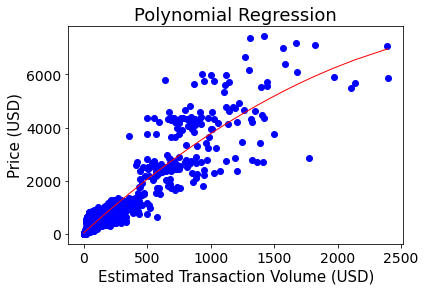

In [96]:
# Fit polynomial regression to btc_estimated_transaction_volume_usd squared vs btc_market_price
poly_btc_estimated_transaction_volume = PolynomialFeatures(degree=2).fit_transform(BTC_data2[["btc_estimated_transaction_volume_usd"]])
fit2 = linear_model.LinearRegression(fit_intercept=True, copy_X=True, n_jobs=1)
fit2.fit(poly_btc_estimated_transaction_volume, BTC_data2["btc_market_price"])
# Make predictions using the testing set
predictions2 = fit2.predict(poly_btc_estimated_transaction_volume)
# Residuals
residuals2 = BTC_data2["btc_market_price"] - predictions2
# The coefficients
print(f'Coefficients: {fit2.coef_}')
# Intercept
print(f'Intercept: {fit2.intercept_}')
# The mean squared error
print("Mean squared error: %.2f"
	  % np.mean((predictions2 - BTC_data2["btc_market_price"]) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % fit2.score(poly_btc_estimated_transaction_volume, BTC_data2["btc_market_price"]))
# Plot outputs
plt.scatter(BTC_data2["btc_estimated_transaction_volume_usd"]/1000000, BTC_data2["btc_market_price"],  color='blue')
plt.plot(np.unique(BTC_data2["btc_estimated_transaction_volume_usd"]/1000000), np.poly1d(np.polyfit(BTC_data2["btc_estimated_transaction_volume_usd"]/1000000, BTC_data2["btc_market_price"], 2))(np.unique(BTC_data2["btc_estimated_transaction_volume_usd"]/1000000)), color='red', linewidth=1)
plt.title('Polynomial Regression')
plt.xlabel('Estimated Transaction Volume (USD)')
plt.ylabel('Price (USD)')
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)
plt.show()

Transaction Volume is significant to Market Price due to R^2 = 0.86



/Users/alvaroserranorivas/.pyenv/versions/3.9.2/envs/bitcoin_linear_regression/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


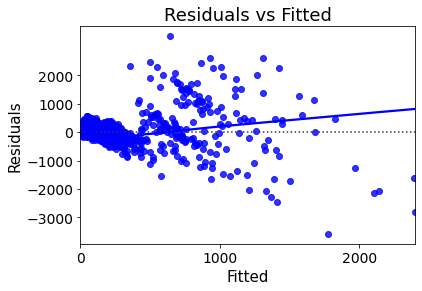

In [97]:
# Residuals vs fitted plot for transaction volume
sns.residplot(BTC_data2["btc_estimated_transaction_volume_usd"]/1000000, BTC_data2["btc_market_price"], lowess=True, color='blue')
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted')
plt.xticks(np.arange(0, max(BTC_data2["btc_estimated_transaction_volume_usd"]/1000000), step=1000))
plt.yticks(np.arange(-3000, 3000, step=1000))
plt.ylabel('Residuals')
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)
plt.show()




- Heteroscedasticity in the residuals plot is not ideal.
	- We can see that the residuals variance increases as the prediction values increase. As the price increases the variability increases. Therefore, a transformation of a variable in the model might be required. 
	- Since most of the load appears to be in bottom, a log transformation will be attempted first.

### Second iteration of Estimated Transaction Volume (USD) and market price

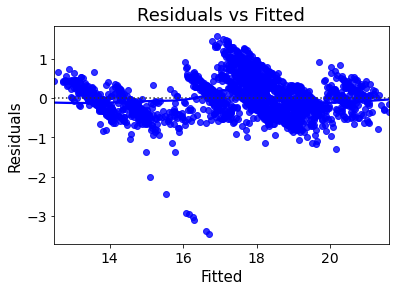

In [98]:
# Residuals vs fitted plot for linear model fit2b
sns.residplot(x=np.log(BTC_data2["btc_estimated_transaction_volume_usd"]), y=np.log(BTC_data2["btc_market_price"]), lowess=True, color='blue')
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted')
plt.ylabel('Residuals')
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=12)
plt.rc('axes', titlesize=18)
plt.show()

Coefficients: [0.9088173]
Intercept: -10.602967594912013
Mean squared error: 0.23
Variance score: 0.93


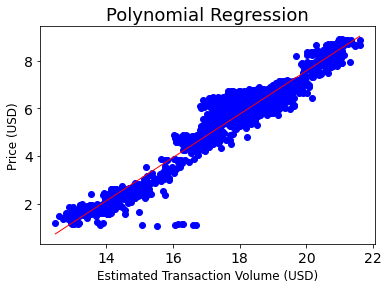

In [99]:
# Fit linear model for log transformed btc_estimated_transaction_volume_usd vs log transformed btc_market_price
fit2b = linear_model.LinearRegression(fit_intercept=True, copy_X=True, n_jobs=1)
fit2b.fit(np.log(BTC_data2[["btc_estimated_transaction_volume_usd"]]), np.log(BTC_data2["btc_market_price"]))
# Make predictions using the testing set
predictions2b = fit2b.predict(np.log(BTC_data2[["btc_estimated_transaction_volume_usd"]]))
# Residuals
residuals2b = np.log(BTC_data2["btc_market_price"]) - np.log(predictions2b)
# The coefficients
print(f'Coefficients: {fit2b.coef_}')
# Intercept
print(f'Intercept: {fit2b.intercept_}')
# The mean squared error
print("Mean squared error: %.2f"
	  % np.mean((predictions2b - np.log(BTC_data2["btc_market_price"])) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % fit2b.score(np.log(BTC_data2[["btc_estimated_transaction_volume_usd"]]), np.log(BTC_data2["btc_market_price"])))
# Plot outputs
plt.scatter(np.log(BTC_data2["btc_estimated_transaction_volume_usd"]), np.log(BTC_data2["btc_market_price"]),  color='blue')
plt.plot(np.unique(np.log(BTC_data2["btc_estimated_transaction_volume_usd"])), np.poly1d(np.polyfit(np.log(BTC_data2["btc_estimated_transaction_volume_usd"]), np.log(BTC_data2["btc_market_price"]), 1))(np.unique(np.log(BTC_data2["btc_estimated_transaction_volume_usd"]))), color='red', linewidth=1)
plt.title('Polynomial Regression')
plt.xlabel('Estimated Transaction Volume (USD)')
plt.ylabel('Price (USD)')
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)
plt.show()


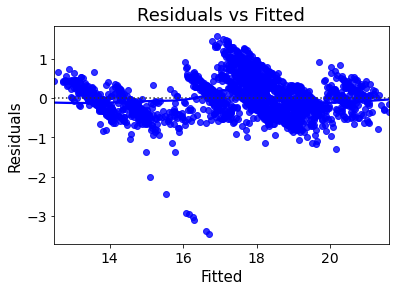

In [100]:
sns.residplot(x=np.log(BTC_data2["btc_estimated_transaction_volume_usd"]), y=np.log(BTC_data2["btc_market_price"]), lowess=True, color='blue')
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted')
plt.ylabel('Residuals')
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=12)
plt.rc('axes', titlesize=18)
plt.show()



- The log transformation improves the heteroscedasticity issue significantly in the x direction
- The dispersion on the y-axis is not ideal but less of pattern

### Miners Revenue and market price


Coefficients: [0.00000000e+00 3.64332297e-04 1.00328375e-11]
Intercept: -67.16047564944654
Mean squared error: 74927.87
Variance score: 0.93


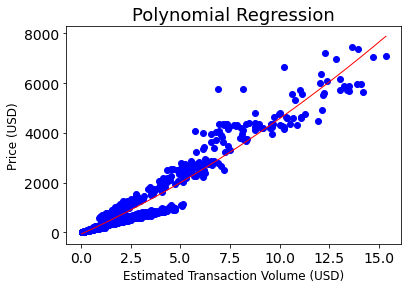

In [101]:
# Fit polynomial regression for btc_miners_revenue vs btc_market_price
poly_btc_miners_revenue = PolynomialFeatures(degree=2).fit_transform(BTC_data2[["btc_miners_revenue"]])
fit3 = linear_model.LinearRegression(fit_intercept=True, copy_X=True, n_jobs=1)
fit3.fit(poly_btc_miners_revenue, BTC_data2["btc_market_price"])
# Make predictions using the testing set
predictions3 = fit3.predict(poly_btc_miners_revenue)
# Residuals
residuals3 = BTC_data2["btc_market_price"] - predictions3
# The coefficients
print(f'Coefficients: {fit3.coef_}')
# Intercept
print(f'Intercept: {fit3.intercept_}')
# The mean squared error
print("Mean squared error: %.2f"
	  % np.mean((predictions3 - BTC_data2["btc_market_price"]) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % fit3.score(poly_btc_miners_revenue, BTC_data2["btc_market_price"]))
# Plot outputs
plt.scatter(BTC_data2["btc_miners_revenue"]/1000000, BTC_data2["btc_market_price"],  color='blue')
plt.plot(np.unique(BTC_data2["btc_miners_revenue"]/1000000), np.poly1d(np.polyfit(BTC_data2["btc_miners_revenue"]/1000000, BTC_data2["btc_market_price"], 2))(np.unique(BTC_data2["btc_miners_revenue"]/1000000)), color='red', linewidth=1)
plt.title('Polynomial Regression')
plt.xlabel('Estimated Transaction Volume (USD)')
plt.ylabel('Price (USD)')
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)
plt.show()


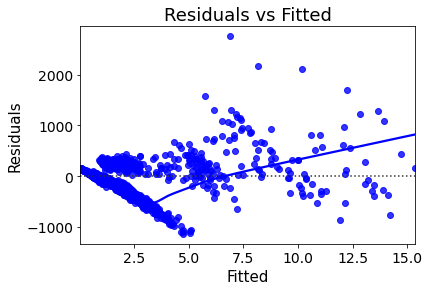

In [102]:
# Residuals vs Fitted
sns.residplot(x=BTC_data2["btc_miners_revenue"]/1000000, y=BTC_data2["btc_market_price"], lowess=True, color='blue')
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted')
plt.ylabel('Residuals')
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=12)
plt.rc('axes', titlesize=18)
plt.show()


We can see that residuals are clustered in a certain area and do not show the best dispersion in terms of heteroscedasticity

### Difficulty and Market Price

Coefficients: [0.00000000e+00 1.51495694e-09 2.28198451e-21]
Intercept: 201.42427930974543
Mean squared error: 69067.73
Variance score: 0.94


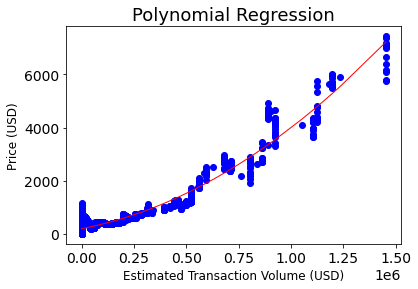

In [103]:
# Fit polynomial regression for btc_difficulty vs btc_market_price
poly_btc_difficulty = PolynomialFeatures(degree=2).fit_transform(BTC_data2[["btc_difficulty"]])
fit4 = linear_model.LinearRegression(fit_intercept=True, copy_X=True, n_jobs=1)
fit4.fit(poly_btc_difficulty, BTC_data2["btc_market_price"])
# Make predictions using the testing set
predictions4 = fit4.predict(poly_btc_difficulty)
# Residuals
residuals4 = BTC_data2["btc_market_price"] - predictions4
# The coefficients
print(f'Coefficients: {fit4.coef_}')
# Intercept
print(f'Intercept: {fit4.intercept_}')
# The mean squared error
print("Mean squared error: %.2f"
	  % np.mean((predictions4 - BTC_data2["btc_market_price"]) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % fit4.score(poly_btc_difficulty, BTC_data2["btc_market_price"]))
# Plot outputs
plt.scatter(BTC_data2["btc_difficulty"]/1000000, BTC_data2["btc_market_price"],  color='blue')
plt.plot(np.unique(BTC_data2["btc_difficulty"]/1000000), np.poly1d(np.polyfit(BTC_data2["btc_difficulty"]/1000000, BTC_data2["btc_market_price"], 2))(np.unique(BTC_data2["btc_difficulty"]/1000000)), color='red', linewidth=1)
plt.title('Polynomial Regression')
plt.xlabel('Estimated Transaction Volume (USD)')
plt.ylabel('Price (USD)')
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)
plt.show()

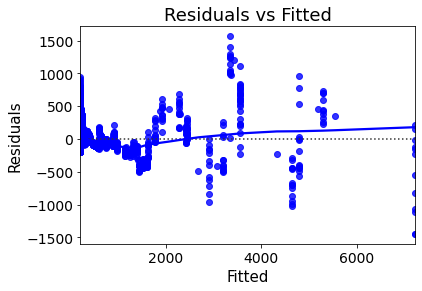

In [104]:
# Plot predictions4 vs residuals4 with sns
sns.residplot(x=predictions4, y=residuals4, lowess=True, color='blue')
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted')
plt.ylabel('Residuals')
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=12)
plt.rc('axes', titlesize=18)
plt.show()


We can see some patterns, and therefore, reject a random dispersion

### Hash Rate and Market Price

Coefficients: [0.00000000e+00 2.62759872e-04 2.93910488e-11]
Intercept: 185.81874208595832
Mean squared error: 110515.97
Variance score: 0.90


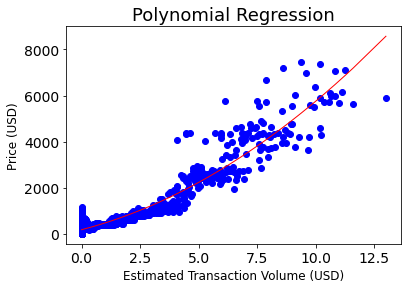

In [105]:
# Fit polynomial regression for btc_hash_rate vs btc_market_price
poly_btc_hash_rate = PolynomialFeatures(degree=2).fit_transform(BTC_data2[["btc_hash_rate"]])
fit5 = linear_model.LinearRegression(fit_intercept=True, copy_X=True, n_jobs=1)
fit5.fit(poly_btc_hash_rate, BTC_data2["btc_market_price"])
# Make predictions using the testing set
predictions5 = fit5.predict(poly_btc_hash_rate)
# Residuals
residuals5 = BTC_data2["btc_market_price"] - predictions5
# The coefficients
print(f'Coefficients: {fit5.coef_}')
# Intercept
print(f'Intercept: {fit5.intercept_}')
# The mean squared error
print("Mean squared error: %.2f"
	  % np.mean((predictions5 - BTC_data2["btc_market_price"]) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % fit5.score(poly_btc_hash_rate, BTC_data2["btc_market_price"]))
# Plot outputs
plt.scatter(BTC_data2["btc_hash_rate"]/1000000, BTC_data2["btc_market_price"],  color='blue')
plt.plot(np.unique(BTC_data2["btc_hash_rate"]/1000000), np.poly1d(np.polyfit(BTC_data2["btc_hash_rate"]/1000000, BTC_data2["btc_market_price"], 2))(np.unique(BTC_data2["btc_hash_rate"]/1000000)), color='red', linewidth=1)
plt.title('Polynomial Regression')
plt.xlabel('Estimated Transaction Volume (USD)')
plt.ylabel('Price (USD)')
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)
plt.show()

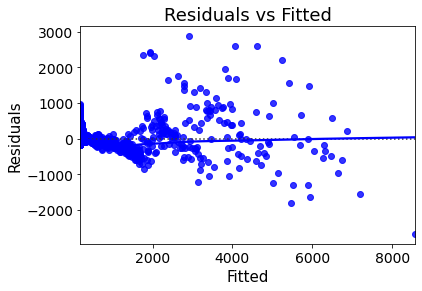

In [106]:
# Residuals vs Fitted
sns.residplot(x=predictions5, y=residuals5, lowess=True, color='blue')
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted')
plt.ylabel('Residuals')
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=12)
plt.rc('axes', titlesize=18)
plt.show()

Despite some heteroscedasticity the residuals mostly follow a flat line